# 3D Cloud Classification : PointNet apply to ModelNet10

In [28]:
#import all the necessary stuffs
import torch
torch.cuda.is_available()
import os
import glob
import trimesh
import numpy as np
from matplotlib import pyplot as plt
import random
import math
import time
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import random
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
#dev = "cpu"  
device = torch.device(dev)  
global device
print(device)

cuda:0


In [29]:
from torch.utils.tensorboard import SummaryWriter

#
#
#      0===============================0
#      |    PLY files reader/writer    |
#      0===============================0
#
#
#------------------------------------------------------------------------------------------
#
#      function to read/write .ply files
#
#------------------------------------------------------------------------------------------
#
#      Hugues THOMAS - 10/02/2017
#


#------------------------------------------------------------------------------------------
#
#          Imports and global variables
#      \**********************************/
#


# Basic libs
import numpy as np
import sys


# Define PLY types
ply_dtypes = dict([
    (b'int8', 'i1'),
    (b'char', 'i1'),
    (b'uint8', 'u1'),
    (b'uchar', 'b1'),
    (b'uchar', 'u1'),
    (b'int16', 'i2'),
    (b'short', 'i2'),
    (b'uint16', 'u2'),
    (b'ushort', 'u2'),
    (b'int32', 'i4'),
    (b'int', 'i4'),
    (b'uint32', 'u4'),
    (b'uint', 'u4'),
    (b'float32', 'f4'),
    (b'float', 'f4'),
    (b'float64', 'f8'),
    (b'double', 'f8')
])

# Numpy reader format
valid_formats = {'ascii': '', 'binary_big_endian': '>',
                 'binary_little_endian': '<'}


#------------------------------------------------------------------------------------------
#
#           Functions
#       \***************/
#

def parse_header(plyfile, ext):

    # Variables
    line = []
    properties = []
    num_points = None

    while b'end_header' not in line and line != b'':
        line = plyfile.readline()
        if b'element' in line:
            line = line.split()
            num_points = int(line[2])

        elif b'property' in line:
            line = line.split()
            properties.append((line[2].decode(), ext + ply_dtypes[line[1]]))

    return num_points, properties


def read_ply(filename):
    """
    Read ".ply" files

    Parameters
    ----------
    filename : string
        the name of the file to read.

    Returns
    -------
    result : array
        data stored in the file

    Examples
    --------
    Store data in file

    >>> points = np.random.rand(5, 3)
    >>> values = np.random.randint(2, size=10)
    >>> write_ply('example.ply', [points, values], ['x', 'y', 'z', 'values'])

    Read the file

    >>> data = read_ply('example.ply')
    >>> values = data['values']
    array([0, 0, 1, 1, 0])

    >>> points = np.vstack((data['x'], data['y'], data['z'])).T
    array([[ 0.466  0.595  0.324]
           [ 0.538  0.407  0.654]
           [ 0.850  0.018  0.988]
           [ 0.395  0.394  0.363]
           [ 0.873  0.996  0.092]])

    """

    with open(filename, 'rb') as plyfile:
        # Check if the file start with ply
        if b'ply' not in plyfile.readline():
            raise ValueError('The file does not start whith the word ply')

        # get binary_little/big or ascii
        fmt = plyfile.readline().split()[1].decode()
        if fmt == "ascii":
            raise ValueError('The file is not binary')

        # get extension for building the numpy dtypes
        ext = valid_formats[fmt]

        # Parse header
        num_points, properties = parse_header(plyfile, ext)

        # Get data
        data = np.fromfile(plyfile, dtype=properties, count=num_points)
    return data


def header_properties(field_list, field_names):

    # List of lines to write
    lines = []

    # First line describing element vertex
    lines.append('element vertex %d' % field_list[0].shape[0])

    # Properties lines
    i = 0
    for fields in field_list:
        for field in fields.T:
            lines.append('property %s %s' % (field.dtype.name, field_names[i]))
            i += 1

    return lines


def write_ply(filename, field_list, field_names):
    """
    Write ".ply" files

    Parameters
    ----------
    filename : string
        the name of the file to which the data is saved. A '.ply' extension will
        be appended to the file name if it does no already have one.

    field_list : list, tuple, numpy array
        the fields to be saved in the ply file. Either a numpy array, a list of
        numpy arrays or a tuple of numpy arrays. Each 1D numpy array and each
        column of 2D numpy arrays are considered as one field.

    field_names : list
        the name of each fields as a list of strings. Has to be the same length
        as the number of fields.

    Examples
    --------
    >>> points = np.random.rand(10, 3)
    >>> write_ply('example1.ply', points, ['x', 'y', 'z'])

    >>> values = np.random.randint(2, size=10)
    >>> write_ply('example2.ply', [points, values], ['x', 'y', 'z', 'values'])

    >>> colors = np.random.randint(255, size=(10,3), dtype=np.uint8)
    >>> field_names = ['x', 'y', 'z', 'red', 'green', 'blue', values']
    >>> write_ply('example3.ply', [points, colors, values], field_names)

    """

    # Format list input to the right form
    field_list = list(field_list) if (type(field_list) == list or type(field_list) == tuple) else list((field_list,))
    for i, field in enumerate(field_list):
        if field is None:
            print('WRITE_PLY ERROR: a field is None')
            return False
        elif field.ndim > 2:
            print('WRITE_PLY ERROR: a field have more than 2 dimensions')
            return False
        elif field.ndim < 2:
            field_list[i] = field.reshape(-1, 1)

    # check all fields have the same number of data
    n_points = [field.shape[0] for field in field_list]
    if not np.all(np.equal(n_points, n_points[0])):
        print('wrong field dimensions')
        return False

    # Check if field_names and field_list have same nb of column
    n_fields = np.sum([field.shape[1] for field in field_list])
    if (n_fields != len(field_names)):
        print('wrong number of field names')
        return False

    # Add extension if not there
    if not filename.endswith('.ply'):
        filename += '.ply'

    # open in text mode to write the header
    with open(filename, 'w') as plyfile:

        # First magical word
        header = ['ply']

        # Encoding format
        header.append('format binary_' + sys.byteorder + '_endian 1.0')

        # Points properties description
        header.extend(header_properties(field_list, field_names))

        # End of header
        header.append('end_header')

        # Write all lines
        for line in header:
            plyfile.write("%s\n" % line)

    # open in binary/append to use tofile
    with open(filename, 'ab') as plyfile:

        # Create a structured array
        i = 0
        type_list = []
        for fields in field_list:
            for field in fields.T:
                type_list += [(field_names[i], field.dtype.str)]
                i += 1
        data = np.empty(field_list[0].shape[0], dtype=type_list)
        i = 0
        for fields in field_list:
            for field in fields.T:
                data[field_names[i]] = field
                i += 1

        data.tofile(plyfile)

    return True


def describe_element(name, df):
    """ Takes the columns of the dataframe and builds a ply-like description

    Parameters
    ----------
    name: str
    df: pandas DataFrame

    Returns
    -------
    element: list[str]
    """
    property_formats = {'f': 'float', 'u': 'uchar', 'i': 'int'}
    element = ['element ' + name + ' ' + str(len(df))]

    if name == 'face':
        element.append("property list uchar int points_indices")

    else:
        for i in range(len(df.columns)):
            # get first letter of dtype to infer format
            f = property_formats[str(df.dtypes[i])[0]]
            element.append('property ' + f + ' ' + df.columns.values[i])

    return element

In [30]:
#define default and custom transformation for 3D cloud objects

class ToTensor(object):
    def __call__(self, pointcloud):
        return torch.from_numpy(pointcloud).to(torch.float32).to(device)
    
class RandomRotation_z(object):
    def __call__(self, pointcloud):
        
        theta = random.random() * 2. * math.pi
        rot_matrix = torch.tensor([[math.cos(theta), -math.sin(theta),      0],
                               [math.sin(theta),  math.cos(theta),      0],
                               [0,                              0,      1]],dtype=torch.float32).to(device)
        rot_pointcloud = torch.matmul(pointcloud,rot_matrix)
        return rot_pointcloud


class RandomNoise(object):
    def __call__(self, pointcloud):
        
        noise = torch.rand(pointcloud.size(0),pointcloud.size(1)).to(device)*0.02
        noisy_pointcloud = pointcloud + noise
        return noisy_pointcloud


class ShufflePoints(object):
    def __call__(self, pointcloud):
        index = torch.randperm(pointcloud.size(0))
        pointcloud[:] = pointcloud[index]
        return pointcloud

    
class AxisReducer(object):
    def __call__(self, pointcloud):
        pointcloud[:,0] = torch.sqrt(torch.square(pointcloud[:,0]) + torch.square(pointcloud[:,1]))
        pointcloud[:,1] = 0
        return pointcloud
    
class NormalizePoints(object):
    def __call__(self, pointcloud):
        return pointcloud/(torch.max(torch.min(pointcloud),torch.max(pointcloud)))
    
    
class PointsToVoxel(object):
    def __call__(self, pointcloud,voxel_size = 4):
        pointcloud= (((pointcloud+1)/2.01)*voxel_size).int()
        return pointcloud

class VoxelToBool(object): #to visualize the result of PointsToVoxel
    def __call__(self, pointcloud,voxel_size = 4):
        bool_array = torch.zeros((voxel_size,voxel_size,voxel_size,),dtype=bool)
        for i in range(pointcloud.size(0)):
            bool_array[pointcloud[i][0],pointcloud[i][1],pointcloud[i][2]]=True
        return bool_array

def default_transforms():
    return transforms.Compose([
        ToTensor(),
        #RandomRotation_z(),
        RandomNoise(),
        ShufflePoints(),
        ])
                              
def customize_transforms():
    return transforms.Compose([
        ToTensor(),
        RandomRotation_z(),
        RandomNoise(),
        AxisReducer(),
        ShufflePoints(),
        ])

def customize_transforms_voxel():
    return transforms.Compose([
        ToTensor(),
        #RandomRotation_z(),
        RandomNoise(),
        NormalizePoints(),
        PointsToVoxel(),
        ShufflePoints(),
        ])


In [31]:
class PointCloudData(Dataset):
    def __init__(self,
                 root_dir,
                 folder="train",
                 transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir))
                   if os.path.isdir(root_dir + "/" + dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir+"/"+category+"/"+folder
            for file in os.listdir(new_dir):
                if file.endswith('.ply'):
                    sample = {}
                    sample['ply_path'] = new_dir+"/"+file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        ply_path = self.files[idx]['ply_path']
        category = self.files[idx]['category']
        data = read_ply(ply_path)
        pointcloud = self.transforms(np.vstack((data['x'],
                                                data['y'],
                                                data['z'])).T)
        return {'pointcloud': pointcloud, 'category': self.classes[category]}
    

    




<Figure size 500x500 with 0 Axes>

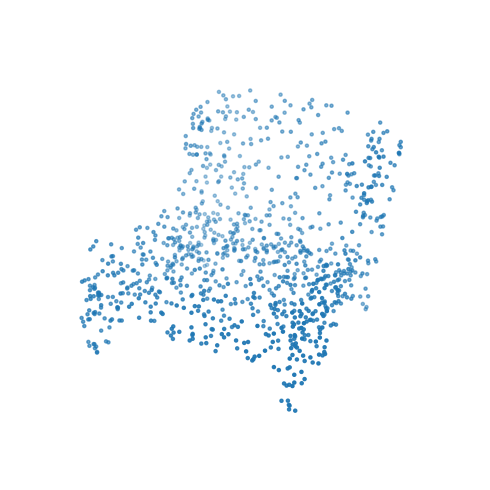

torch.Size([4, 4, 4])


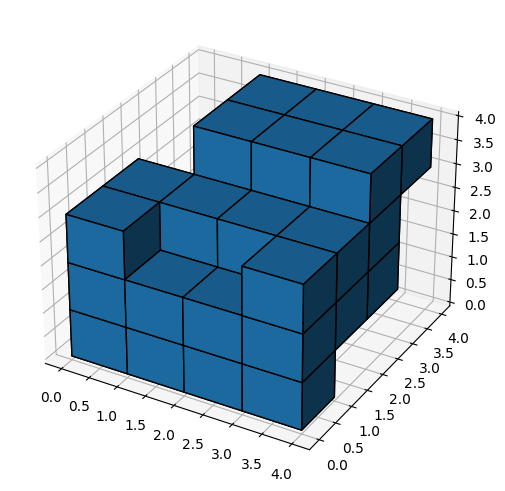

torch.Size([4, 4, 4])


In [32]:

NUM_POINTS = 1024
NUM_CLASSES = 10
BATCH_SIZE = 32


train_ds = PointCloudData("./data/ModelNet10_PLY")
test_ds = PointCloudData("./data/ModelNet10_PLY", folder='test')


dataloader_train = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)



train_ds_augment = PointCloudData("./data/ModelNet10_PLY",transform=customize_transforms())
test_ds_augment = PointCloudData("./data/ModelNet10_PLY", folder='test',transform=customize_transforms())

dataloader_train_augment = DataLoader(train_ds_augment, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test_augment = DataLoader(test_ds_augment, batch_size=BATCH_SIZE, shuffle=True)

train_ds_augment_voxel = PointCloudData("./data/ModelNet10_PLY",transform=customize_transforms_voxel())
test_ds_augment_voxel = PointCloudData("./data/ModelNet10_PLY", folder='test',transform=customize_transforms_voxel())

dataloader_train_augment_voxel = DataLoader(train_ds_augment_voxel, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test_augment_voxel = DataLoader(test_ds_augment_voxel, batch_size=BATCH_SIZE, shuffle=True)



#3710
index =800


plt.figure(1)
points = train_ds[index]["pointcloud"].cpu()


plt.figure(1)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],s=5)
ax.set_axis_off()
plt.show()



points = train_ds_augment_voxel[index]["pointcloud"].cpu()

voxel_to_bool = VoxelToBool()

voxelarray = voxel_to_bool(points)
print(voxelarray.shape)


plt.rcParams["figure.figsize"] = [5,5]
plt.rcParams["figure.autolayout"] = True
ax = plt.figure(2).add_subplot(projection='3d')



#ax.voxels(voxelarray, edgecolor="k",facecolors="red")
ax.voxels(voxelarray, edgecolor='k')

plt.show()
print(voxelarray.shape)


In [33]:

num_classes = 10

titles_object =[]
for key in train_ds_augment.classes:
    titles_object.append(key)

# fig, ax = plt.subplots(num_classes, 5, figsize=(10,20))
fig = plt.figure(figsize=(14,20))

sliced_dataset = slice_dataset(train_ds)

size_x = 7
for i in range(num_classes):
    for j in range(size_x):
        points = sliced_dataset[i][j].cpu()
        
        ax = fig.add_subplot(num_classes, size_x, 1+i*size_x+j, projection='3d')
        plt.title(titles_object[i]+" : "+str(j))

        ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)
        
        
        ax.set_axis_off()




plt.legend()
plt.show()

print("Numbers of each object")
for i in range(num_classes):
    print(i,len(sliced_dataset[i]))
    
del sliced_dataset


NameError: name 'slice_dataset' is not defined

<Figure size 1400x2000 with 0 Axes>

In [ ]:
a.count(0)

In [59]:


   


def plot_all(accuracy_train_array,accuracy_test_array,loss_train_array,loss_test_array):
    plt.figure(1)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy in %")
    plt.plot(accuracy_train_array,label="Accuracy train")
    plt.plot(accuracy_test_array,label="Accuracy test")

    plt.legend()
    plt.show()
    plt.figure(2)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.plot(loss_train_array,label="Loss train")
    plt.plot(loss_test_array,label="Loss test")

    plt.legend()
    plt.show()
def basic_loss(outputs, labels):

    #outputs,labels =  torch.Tensor(outputs,dtype=torch.long),torch.Tensor(labels,dtype=torch.long)
    #criterion = torch.nn.NLLLoss()
    criterion = torch.nn.CrossEntropyLoss()
    #criterion = torch.nn.CrossEntropyLoss()
    bsize = outputs.size(0)
    #outputs = torch.transpose(outputs,0, 1)
    return criterion(outputs, labels)


def pointnet_full_loss(outputs, labels, m1, m2, loss_func, alpha=0.001):
    #criterion = torch.nn.NLLLoss()
    criterion = loss_func
    #criterion = torch.nn.CrossEntropyLoss()
    bsize = outputs.size(0)

    
    id_1 = torch.eye(m1.size(1), requires_grad=True).repeat(bsize, 1, 1).to(device)
    diff1 = id_1 - torch.bmm(m1, m1.transpose(1, 2))
    
    id_2 = torch.eye(m2.size(1), requires_grad=True).repeat(bsize, 1, 1).to(device)
    diff2 = id_2 - torch.bmm(m2, m2.transpose(1, 2))
    
    
    return criterion(outputs, labels) + alpha * (torch.norm(diff1)) / float(bsize) + alpha * (torch.norm(diff2)) / float(bsize)

def get_accuracy(labels_predict,labels_true):
    _, predicted = torch.max(labels_predict.data, 1)
    total = labels_true.size(0)
    
#     print(labels_true.shape)
#     print(predicted.shape)
#     print(total)
    
    correct = (predicted == labels_true).sum().item()
    val_acc = 100. * correct / total
    
#     print(val_acc)
    return val_acc


def get_accuracy_multi(labels_predict,labels_true):
    accuracy_objects = []
    for i in range(10):
        accuracy_objects.append(0)
        
    _, predicted = torch.max(labels_predict, 1)
    for i in range(10):
        nb_label = torch.where(labels_true==i, 1,0).sum()
        if nb_label !=0:
            accuracy_objects[i] = (((torch.where(labels_true==i, predicted,-1) == labels_true).sum().item())/ nb_label)*100.0
    
    return accuracy_objects

def evaluation_model(model,dataloader_test,loss_func):
    correct = total = 0
    loss_test=0
    val_acc_test=0
    size=0
    with torch.no_grad():
        for id_batch, data in enumerate(dataloader_test):
            inputs, labels = data['pointcloud'].float(), data['category']
            size+=1
            predicted,rotation_1,rotation_2 = model(inputs)
                        # outputs, __ = model(inputs.transpose(1,2))

            predicted, labels = torch.Tensor(predicted).type(torch.FloatTensor),torch.Tensor(labels).type(torch.LongTensor)
            #loss_test = basic_loss(predicted, labels)
            loss_test += pointnet_full_loss(predicted, labels,rotation_1,rotation_2,loss_func)
            val_acc_test += get_accuracy(predicted,labels)
        
    return loss_test/size,val_acc_test/size




def test_model_multi_objects(model,dataloader_train,dataloader_test):
    accuracy_array_train = []
    accuracy_array_test = []
    for i in range(10):
        accuracy_array_train.append(0)
        accuracy_array_test.append(0)
    
    size_train=0
    size_test=0
    with torch.no_grad():
        for id_batch, data in enumerate(dataloader_train):
            inputs, labels = data['pointcloud'].float(), data['category'].cpu()
            size_train+=1
            predicted,rotation_1,rotation_2 = model(inputs)
            
            acc_o = get_accuracy_multi(predicted.cpu(),labels)
            for i in range(10):
                accuracy_array_train[i] += acc_o[i]
            
        for id_batch, data in enumerate(dataloader_test):
            inputs, labels = data['pointcloud'].float(), data['category'].cpu()
            size_test+=1
            predicted,rotation_1,rotation_2 = model(inputs)
            acc_o = get_accuracy_multi(predicted.cpu(),labels)
            for i in range(10):
                accuracy_array_test[i] += acc_o[i]
            
            
    for i in range(10):
        accuracy_array_train[i] = accuracy_array_train[i]/size_train
        accuracy_array_test[i] = accuracy_array_test[i]/size_test
    return accuracy_array_train,accuracy_array_test


#     return accuracy_array_train,accuracy_array_test
        
        

def train(
    model,
    dataloader_train, 
    dataloader_test,  
    epochs=100, 
    loss_func=torch.nn.NLLLoss(),
    multi_object=False,
):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=20, gamma=0.5)
    loss_train = 0

        
    
    (
        loss_train_array,accuracy_train_array,
        loss_test_array,accuracy_test_array,
        accuracy_train_array_multi,
        accuracy_test_array_multi
    )= [],[],[],[],[],[]
    
    
    for epoch in range(epochs):
        
        for id_batch, data in enumerate(dataloader_train):
            inputs, labels = data['pointcloud'].float(), data['category']

            #model.train()

            #inputs, labels = torch.FloatTensor(),torch.FloatTensor()

            optimizer.zero_grad()

            labels_predict,rotation_1,rotation_2 = model(inputs)

            labels_predict, labels = torch.Tensor(labels_predict).type(torch.FloatTensor),torch.Tensor(labels).type(torch.LongTensor)
            #loss_train = basic_loss(labels_predict, labels)

            loss_train = pointnet_full_loss(labels_predict, labels,rotation_1,rotation_2,loss_func)
        
            
            loss_train.backward()
            optimizer.step()
            #print(id_batch)
            if id_batch==0:

                    # loss = pointnet_full_loss(outputs, labels, m3x3)

                acc_train = get_accuracy(labels_predict,labels)
                loss_train_array.append(loss_train.cpu().detach().numpy())
                accuracy_train_array.append(acc_train)
                scheduler.step()
                loss_test,acc_test=evaluation_model(model,dataloader_test,loss_func)
                loss_test_array.append(loss_test.cpu().detach().numpy())
                accuracy_test_array.append(acc_test)
                
                if multi_object:
                    acc_train_multi,acc_test_multi = test_model_multi_objects(model,dataloader_train,dataloader_test)
                    
                    accuracy_train_array_multi.append(acc_train_multi)
                    accuracy_test_array_multi.append(acc_test_multi)

                print('Epoch: %d, Loss_train: %.3f, Accuracy_train: %.1f %%, Loss_test %.3f, Accuracy_test: %.1f %%' % (epoch+1, loss_train, acc_train,loss_test, acc_test))
    if multi_object:
        print("Final accuracy over the objects : ")
        print("Accuracy_train",accuracy_train_array_multi[-1],"% Accuracy_test : ",accuracy_test_array_multi[-1],"%")
        return (
            loss_train_array,
            accuracy_train_array,
            loss_test_array,
            accuracy_test_array,
            accuracy_train_array_multi,
            accuracy_test_array_multi
        )
    return loss_train_array,accuracy_train_array,loss_test_array,accuracy_test_array



Epoch: 1, Loss_train: 2.265, Accuracy_train: 18.8 %, Loss_test 2.011, Accuracy_test: 30.1 %
Epoch: 2, Loss_train: 0.524, Accuracy_train: 81.2 %, Loss_test 0.521, Accuracy_test: 83.5 %
Epoch: 3, Loss_train: 0.209, Accuracy_train: 93.8 %, Loss_test 0.382, Accuracy_test: 87.5 %
Epoch: 4, Loss_train: 0.041, Accuracy_train: 100.0 %, Loss_test 0.419, Accuracy_test: 84.5 %
Epoch: 5, Loss_train: 0.181, Accuracy_train: 90.6 %, Loss_test 0.373, Accuracy_test: 87.6 %
Epoch: 6, Loss_train: 0.202, Accuracy_train: 93.8 %, Loss_test 0.365, Accuracy_test: 87.6 %
Epoch: 7, Loss_train: 0.197, Accuracy_train: 93.8 %, Loss_test 0.367, Accuracy_test: 87.5 %
Epoch: 8, Loss_train: 0.083, Accuracy_train: 96.9 %, Loss_test 0.360, Accuracy_test: 87.3 %
Epoch: 9, Loss_train: 0.282, Accuracy_train: 93.8 %, Loss_test 0.355, Accuracy_test: 88.2 %
Epoch: 10, Loss_train: 0.215, Accuracy_train: 96.9 %, Loss_test 0.359, Accuracy_test: 87.2 %
Epoch: 11, Loss_train: 0.204, Accuracy_train: 96.9 %, Loss_test 0.318, Accurac

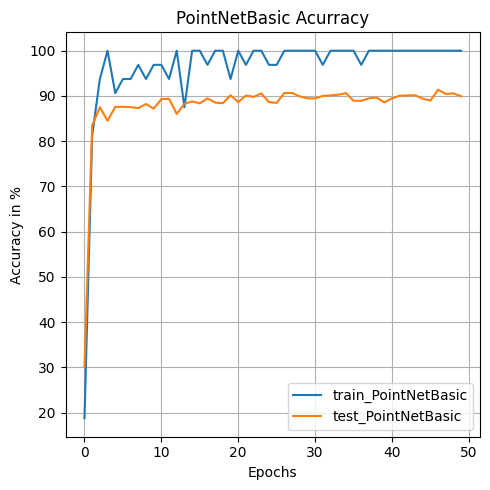

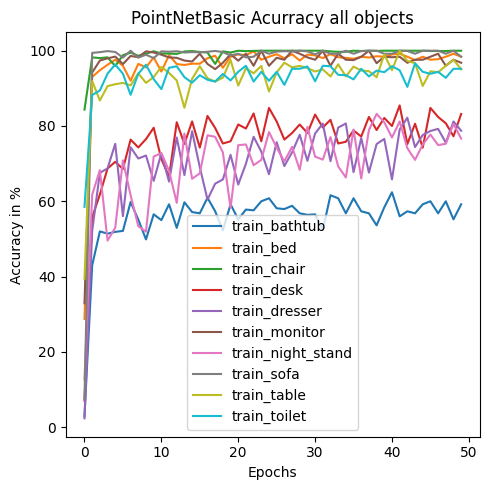

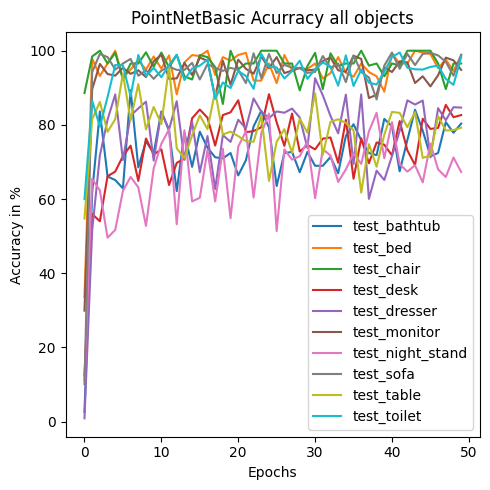

In [60]:
#PointMLP, no augment
model = PointNetBasic(NUM_POINTS,NUM_CLASSES)
(loss_train_array_PointNetBasic,
 accuracy_train_array_PointNetBasic,
 loss_test_array_PointNetBasic,
 accuracy_test_array_PointNetBasic,
 accuracy_train_array_multi_PointNetBasic,
 accuracy_test_array_multi_PointNetBasic
) = train(
    model, 
    dataloader_train,
    dataloader_test, 
    epochs=50,
    loss_func=torch.nn.CrossEntropyLoss(),
    multi_object = True,
)

plt.figure(1)
plt.title("PointNetBasic Acurracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy in %")

plt.plot(accuracy_train_array_PointNetBasic,label="train_PointNetBasic")
plt.plot(accuracy_test_array_PointNetBasic,label="test_PointNetBasic")
plt.grid()
plt.legend()


name_curve_train = []
name_curve_test = []
for i in range(10):
    name_curve_train.append("train_"+titles_object[i])
    name_curve_test.append("test_"+titles_object[i])

#titles_object
plt.figure(2)
plt.title("PointNetBasic Acurracy all objects")
plt.xlabel("Epochs")
plt.ylabel("Accuracy in %")
plt.plot(accuracy_train_array_multi_PointNetBasic,label=name_curve_train)
plt.legend()

plt.figure(3)
plt.title("PointNetBasic Acurracy all objects")
plt.xlabel("Epochs")
plt.ylabel("Accuracy in %")
plt.plot(accuracy_test_array_multi_PointNetBasic,label=name_curve_test)
plt.legend()


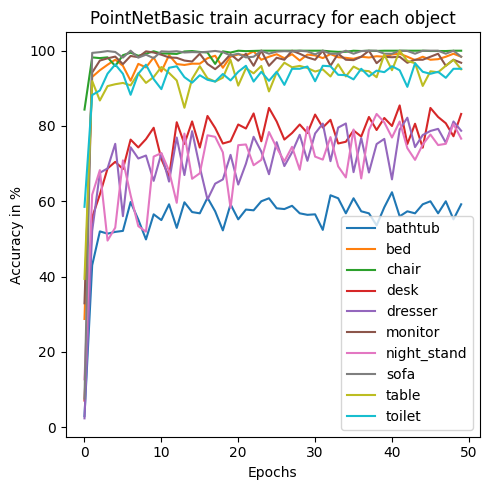

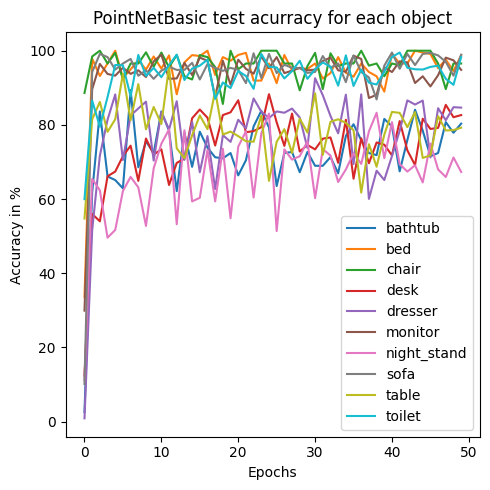

In [62]:

name_curve_train = []
name_curve_test = []
for i in range(10):
    name_curve_train.append(titles_object[i])
    name_curve_test.append(titles_object[i])

    
plt.figure(2)
plt.title("PointNetBasic train acurracy for each object")
plt.xlabel("Epochs")
plt.ylabel("Accuracy in %")
plt.plot(accuracy_train_array_multi_PointNetBasic,label=name_curve_train)
plt.legend()

plt.figure(3)
plt.title("PointNetBasic test acurracy for each object")
plt.xlabel("Epochs")
plt.ylabel("Accuracy in %")
plt.plot(accuracy_test_array_multi_PointNetBasic,label=name_curve_test)
plt.legend()

In [ ]:


class PointMLP(nn.Module):
    def __init__(self, input_size, classes=10):
        super(PointMLP, self).__init__()
        l_1 = 512
        l_2 = 256

        self.fc_1 = nn.Linear(NUM_POINTS*3,l_1).to(device)
        self.bn_1 = nn.BatchNorm1d(l_1).to(device)
        self.fc_2 = nn.Linear(l_1,l_2).to(device)
        self.dropout_1 = nn.Dropout(0.3).to(device)
        self.bn_2 = nn.BatchNorm1d(l_2).to(device)

        self.fc_3 = nn.Linear(l_2,classes).to(device)
        self.bn_3 = nn.BatchNorm1d(classes).to(device)
        
        self.eye_1 = torch.eye(1, requires_grad=False)
        self.eye_2 = torch.eye(1, requires_grad=False)

    
    def forward(self, x):
        x = x.to(device)

        x = torch.flatten(x,start_dim=1)
        x = self.fc_1(x)
        x = self.bn_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = self.dropout_1(x)
        x = self.bn_2(x)
        x = F.relu(x)
        x = self.fc_3(x)
        x = self.bn_3(x)
        x = F.relu(x)
        return x,self.eye_1.repeat(x.size(0), 1, 1).to(device),self.eye_2.repeat(x.size(0), 1, 1).to(device)


class Tnet(nn.Module):
    def __init__(self, input_size, kernel_size):
        super(Tnet, self).__init__()
        #l_1 = 64
        #l_2 = 128
        #l_3 = 1024
        #l_4 = 512
        #l_5 = 256

        l_1 = 32
        l_2 = 64
        l_3 = 256
        l_4 = 128
        l_5 = 64

        self.kn_size = kernel_size

        self.fc_1 = nn.Conv1d(kernel_size,l_1,1).to(device)
        self.bn_1 = nn.BatchNorm1d(l_1).to(device)
        self.fc_2 = nn.Conv1d(l_1,l_2,1).to(device)
        self.bn_2 = nn.BatchNorm1d(l_2).to(device)
        self.fc_3 = nn.Conv1d(l_2,l_3,1).to(device)
        self.bn_3 = nn.BatchNorm1d(l_3).to(device)

        self.mp = nn.MaxPool1d(l_3).to(device)
        self.fc_4 = nn.Linear(input_size,l_4).to(device)
        self.bn_4 = nn.BatchNorm1d(l_4).to(device)
        self.fc_5 = nn.Linear(l_4,l_5).to(device)
        self.bn_5 = nn.BatchNorm1d(l_5).to(device)
        self.fc_6 = nn.Linear(l_5,self.kn_size*self.kn_size).to(device)

    def forward(self, x):
        x = x.to(device)

        #x = torch.flatten(x,start_dim=-2)
        x = x.transpose(2, 1)
        x = self.fc_1(x)
        x = self.bn_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = self.bn_2(x)
        x = F.relu(x)
        x = self.fc_3(x)
        x = self.bn_3(x)
        x = F.relu(x)

        x = self.mp(x)
        x = torch.flatten(x,start_dim=1)
        x = self.fc_4(x)
        x = self.bn_4(x)
        x = F.relu(x)
        x = self.fc_5(x)
        x = self.bn_5(x)
        x = F.relu(x)
        x = self.fc_6(x)
        x = x.view(-1,self.kn_size,self.kn_size)
        return x

class InputTransform(nn.Module):
    def __init__(self,input_size, kernel_size):
        super(InputTransform, self).__init__()
        self.kn_size = kernel_size

        self.t_net = Tnet(input_size, kernel_size).to(device)

    def forward(self, x):
        x = x.to(device)
        kern = self.t_net(x)
        x = torch.matmul(x,kern)
        return x,kern


class PointNetBasic(nn.Module):
    def __init__(self, input_size,classes=10):
        super(PointNetBasic, self).__init__()
        #l_1 = 64
        #l_2 = 64
        #l_3 = 64
        #l_4 = 128
        #l_5 = 1024
        #l_6 = 512
        #l_7 = 256

        l_1 = 32
        l_2 = 32
        l_3 = 32
        l_4 = 128
        l_5 = 512
        l_6 = 256
        l_7 = 128

        self.fc_1 = nn.Conv1d(3,l_1,1).to(device)
        self.bn_1 = nn.BatchNorm1d(l_1).to(device)
        self.fc_2 = nn.Conv1d(l_1,l_2,1).to(device)
        self.bn_2 = nn.BatchNorm1d(l_2).to(device)
        self.fc_3 = nn.Conv1d(l_2,l_3,1).to(device)
        self.bn_3 = nn.BatchNorm1d(l_3).to(device)
        self.fc_4 = nn.Conv1d(l_3,l_4,1).to(device)
        self.bn_4 = nn.BatchNorm1d(l_4).to(device)
        self.fc_5 = nn.Conv1d(l_4,l_5,1).to(device)
        self.bn_5 = nn.BatchNorm1d(l_5).to(device)

        self.mp = nn.MaxPool1d(l_5).to(device)
        self.fc_6 = nn.Linear(input_size,l_6).to(device)
        self.bn_6 = nn.BatchNorm1d(l_6).to(device)
        self.fc_7 = nn.Linear(l_6,l_7).to(device)
        self.dropout_1 = nn.Dropout(0.3).to(device)
        self.bn_7 = nn.BatchNorm1d(l_7).to(device)
        self.fc_8 = nn.Linear(l_7,classes).to(device)
        self.eye_1 = torch.eye(1, requires_grad=False)
        self.eye_2 = torch.eye(1, requires_grad=False)
    
    def forward(self, x):
        x=x.to(device)
        x = x.transpose(2, 1)
        x = self.fc_1(x)
        x = self.bn_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = self.bn_2(x)
        x = F.relu(x)
        x = self.fc_3(x)
        x = self.bn_3(x)
        x = F.relu(x)
        x = self.fc_4(x)
        x = self.bn_4(x)
        x = F.relu(x)
        x = self.fc_5(x)
        x = self.bn_5(x)
        x = F.relu(x)

        x = self.mp(x)
        x = torch.flatten(x,start_dim=1)

        x = self.fc_6(x)
        x = self.bn_6(x)
        x = F.relu(x)
        x = self.fc_7(x)
        x = self.bn_7(x)
        x = F.relu(x)
        x = self.dropout_1(x)
        x = self.fc_8(x)
        return x,self.eye_1.repeat(x.size(0), 1, 1).to(device),self.eye_2.repeat(x.size(0), 1, 1).to(device)




class PointNetFull(nn.Module):
    def __init__(self, input_size,classes=10):
        super(PointNetFull, self).__init__()
        #l_1 = 64
        #l_2 = 64
        #l_3 = 64
        #l_4 = 128
        #l_5 = 1024
        #l_6 = 512
        #l_7 = 256
        
        l_1 = 32
        l_2 = 32
        l_3 = 32
        l_4 = 128
        l_5 = 512
        l_6 = 256
        l_7 = 128
        
        #torch.nn.Conv1d(3, 64, 1)
        self.input_transform_1 = InputTransform(input_size,3).to(device)
        
        self.fc_1 = nn.Conv1d(3,l_1,1).to(device)
        self.bn_1 = nn.BatchNorm1d(l_1).to(device)
        self.fc_2 = nn.Conv1d(l_1,l_2,1).to(device)
        self.bn_2 = nn.BatchNorm1d(l_2).to(device)
        
        self.fc_3 = nn.Conv1d(l_2,l_3,1).to(device)
        self.bn_3 = nn.BatchNorm1d(l_3).to(device)
        self.fc_4 = nn.Conv1d(l_3,l_4,1).to(device)
        self.bn_4 = nn.BatchNorm1d(l_4).to(device)
        self.fc_5 = nn.Conv1d(l_4,l_5,1).to(device)
        self.bn_5 = nn.BatchNorm1d(l_5).to(device)
        
        self.mp = nn.MaxPool1d(l_5).to(device)
        self.fc_6 = nn.Linear(input_size,l_6).to(device)
        self.bn_6 = nn.BatchNorm1d(l_6).to(device)
        self.fc_7 = nn.Linear(l_6,l_7).to(device)
        self.dropout_1 = nn.Dropout(0.3).to(device)
        self.bn_7 = nn.BatchNorm1d(l_7).to(device)
        self.fc_8 = nn.Linear(l_7,classes).to(device)
        self.eye_1 = torch.eye(1, requires_grad=False)
        self.eye_2 = torch.eye(1, requires_grad=False)

    def forward(self, x):
        x=x.to(device)
        x,rotation_1 = self.input_transform_1(x)
        
        x = x.transpose(2, 1)
        x = self.fc_1(x)
        x = self.bn_1(x)
        x = F.relu(x)
        
        x = self.fc_2(x)
        x = self.bn_2(x)
        x = F.relu(x)
        
        x = self.fc_3(x)
        x = self.bn_3(x)
        x = F.relu(x)
        
        x = self.fc_4(x)
        x = self.bn_4(x)
        x = F.relu(x)
        
        x = self.fc_5(x)
        x = self.bn_5(x)
        x = F.relu(x)
        
        x = self.mp(x)
        x = torch.flatten(x,start_dim=1)
        
        x = self.fc_6(x)
        x = self.bn_6(x)
        x = F.relu(x)
        
        x = self.fc_7(x)
        x = self.bn_7(x)
        x = F.relu(x)
        x = self.dropout_1(x)
        x = self.fc_8(x)
        return x,rotation_1,self.eye_1.repeat(x.size(0), 1, 1).to(device)







In [ ]:
#PointMLP, no augment
model = PointMLP(NUM_POINTS,NUM_CLASSES)
(loss_train_array_POINTMLP,
 accuracy_train_array_POINTMLP,
 loss_test_array_POINTMLP,
 accuracy_test_array_POINTMLP) = train(
    model, 
    dataloader_train,
    dataloader_test, 
    epochs=50,
    loss_func=torch.nn.CrossEntropyLoss()
)

plt.figure(1)
plt.title("PointMLP Acurracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy in %")

plt.plot(accuracy_train_array_POINTMLP,label="train_PointMLP")
plt.plot(accuracy_test_array_POINTMLP,label="test_PointMLP")
plt.grid()
plt.legend()



In [ ]:
#PointBasic, no augment
model = PointNetBasic(NUM_POINTS,NUM_CLASSES)
(loss_train_array_POINTNetBasic,
 accuracy_train_array_POINTNetBasic,
 loss_test_array_POINTNetBasic,
 accuracy_test_array_POINTNetBasic) = train(
    model, 
    dataloader_train,
    dataloader_test, 
    epochs=50,
    loss_func=torch.nn.CrossEntropyLoss()
)



plt.figure(1)
plt.title("PointNetBasic Acurracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy in %")

plt.plot(accuracy_train_array_POINTNetBasic,label="train_PointNetBasic")
plt.plot(accuracy_test_array_POINTNetBasic,label="test_PointNetBasic")
plt.grid()
plt.legend()

--
Epoch: 1, Loss_train: 2.312, Accuracy_train: 18.8 %, Loss_test 2.399, Accuracy_test: 9.4 %
---------------------
Epoch: 21, Loss_train: 0.173, Accuracy_train: 93.8 %, Loss_test 0.518, Accuracy_test: 83.7 %
---------------------
Epoch: 41, Loss_train: 0.117, Accuracy_train: 96.9 %, Loss_test 0.518, Accuracy_test: 84.6 %
---------

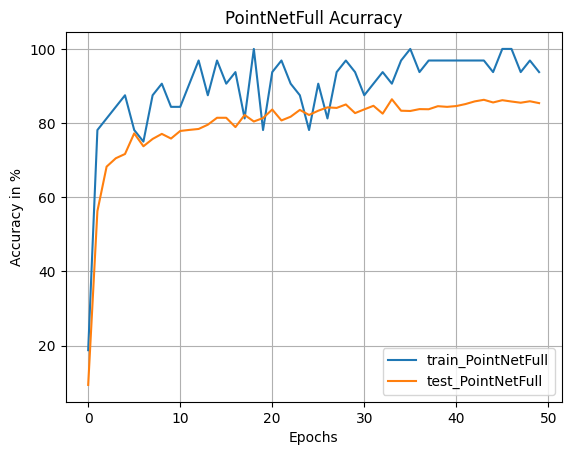

In [53]:
#PointFull, no augment
model = PointNetFull(NUM_POINTS,NUM_CLASSES)
(loss_train_array_POINTNetFull,
 accuracy_train_array_POINTNetFull,
 loss_test_array_POINTNetFull,
 accuracy_test_array_POINTNetFull) = train(
    model, 
    dataloader_train,
    dataloader_test, 
    epochs=50,
    loss_func=torch.nn.CrossEntropyLoss()
)

plt.figure(1)
plt.title("PointNetFull Acurracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy in %")

plt.plot(accuracy_train_array_POINTNetFull,label="train_PointNetFull")
plt.plot(accuracy_test_array_POINTNetFull,label="test_PointNetFull")
plt.grid()
plt.legend()



NameError: name 'accuracy_train_array_POINTNetFull' is not defined

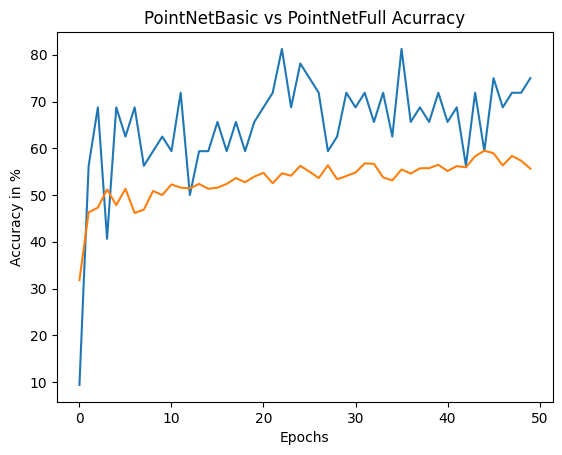

In [52]:
plt.figure(1)
plt.title("PointNetBasic vs PointNetFull Acurracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy in %")
plt.plot(accuracy_train_array_POINTNetBasic,label="train_PointNetBasic")
plt.plot(accuracy_test_array_POINTNetBasic,label="test_PointNetBasic")
plt.plot(accuracy_train_array_POINTNetFull,label="train_PointNetFull")
plt.plot(accuracy_test_array_POINTNetFull,label="test_PointNetFull")
plt.grid()
plt.legend()



--
Epoch: 1, Loss_train: 2.197, Accuracy_train: 25.0 %, Loss_test 2.018, Accuracy_test: 34.8 %
---------------------
Epoch: 21, Loss_train: 0.085, Accuracy_train: 96.9 %, Loss_test 0.546, Accuracy_test: 85.2 %
---------------------
Epoch: 41, Loss_train: 0.048, Accuracy_train: 100.0 %, Loss_test 0.638, Accuracy_test: 84.3 %
---------

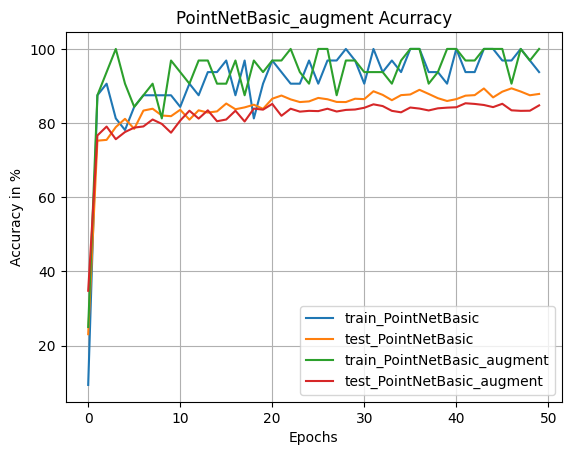

In [56]:

#PointFull, augment, AxisReducing
model = PointNetBasic(NUM_POINTS,NUM_CLASSES)
(loss_train_array_POINTNetBasic_augment,
 accuracy_train_array_POINTNetBasic_augment,
 loss_test_array_POINTNetBasic_augment,
 accuracy_test_array_POINTNetBasic_augment) = train(
    model, 
    dataloader_train_augment,
    dataloader_test_augment, 
    epochs=50,
    loss_func=torch.nn.CrossEntropyLoss()
)

plt.figure(1)
plt.title("PointNetBasic_augment Acurracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy in %")

plt.plot(accuracy_train_array_POINTNetBasic,label="train_PointNetBasic")
plt.plot(accuracy_test_array_POINTNetBasic,label="test_PointNetBasic")

plt.plot(accuracy_train_array_POINTNetBasic_augment,label="train_PointNetBasic_augment")
plt.plot(accuracy_test_array_POINTNetBasic_augment,label="test_PointNetBasic_augment")
plt.grid()
plt.legend()



--
Epoch: 1, Loss_train: 2.455, Accuracy_train: 6.2 %, Loss_test 2.127, Accuracy_test: 21.8 %
---------------------
Epoch: 21, Loss_train: 0.429, Accuracy_train: 84.4 %, Loss_test 0.772, Accuracy_test: 74.5 %
---------------------
Epoch: 41, Loss_train: 0.424, Accuracy_train: 84.4 %, Loss_test 0.763, Accuracy_test: 76.9 %
---------

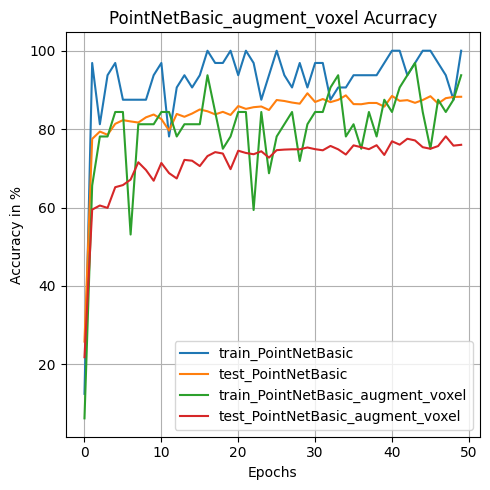

In [106]:
#PointNetBasic, augment, voxel
model = PointNetBasic(NUM_POINTS,NUM_CLASSES)
(loss_train_array_POINTNetBasic_augment_voxel,
 accuracy_train_array_POINTNetBasic_augment_voxel,
 loss_test_array_POINTNetBasic_augment_voxel,
 accuracy_test_array_POINTNetBasic_augment_voxel) = train(
    model, 
    dataloader_train_augment_voxel,
    dataloader_test_augment_voxel, 
    epochs=50,
    loss_func=torch.nn.CrossEntropyLoss()
)

plt.figure(1)
plt.title("PointNetBasic_augment_voxel Acurracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy in %")

plt.plot(accuracy_train_array_POINTNetBasic,label="train_PointNetBasic")
plt.plot(accuracy_test_array_POINTNetBasic,label="test_PointNetBasic")

plt.plot(accuracy_train_array_POINTNetBasic_augment_voxel,label="train_PointNetBasic_augment_voxel")
plt.plot(accuracy_test_array_POINTNetBasic_augment_voxel,label="test_PointNetBasic_augment_voxel")
plt.grid()
plt.legend()


In [121]:
model = PointMLP(NUM_POINTS,NUM_CLASSES)
print(model)

PointMLP(
  (fc_1): Linear(in_features=3072, out_features=512, bias=True)
  (bn_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_2): Linear(in_features=512, out_features=256, bias=True)
  (dropout_1): Dropout(p=0.3, inplace=False)
  (bn_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_3): Linear(in_features=256, out_features=1024, bias=True)
  (bn_3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [122]:
model = PointNetBasic(NUM_POINTS,NUM_CLASSES)
print(model)

PointNetBasic(
  (fc_1): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
  (bn_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  (bn_2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_3): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  (bn_3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_4): Conv1d(32, 128, kernel_size=(1,), stride=(1,))
  (bn_4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_5): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
  (bn_5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp): MaxPool1d(kernel_size=512, stride=512, padding=0, dilation=1, ceil_mode=False)
  (fc_6): Linear(in_features=1024, out_features=256, bias=True)
  (bn_6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_7):

In [123]:
model = PointNetFull(NUM_POINTS,NUM_CLASSES)
print(model)

PointNetFull(
  (input_transform_1): InputTransform(
    (t_net): Tnet(
      (fc_1): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
      (bn_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc_2): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc_3): Conv1d(64, 256, kernel_size=(1,), stride=(1,))
      (bn_3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (mp): MaxPool1d(kernel_size=256, stride=256, padding=0, dilation=1, ceil_mode=False)
      (fc_4): Linear(in_features=1024, out_features=128, bias=True)
      (bn_4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc_5): Linear(in_features=128, out_features=64, bias=True)
      (bn_5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc_6): Linear(in_features=64, out_features=9